# JSON exercise (_solution_)
****

## 1. Find the 10 countries with most projects

In [755]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import json

df = pd.read_json('data/world_bank_projects.json')

#### Compute the number of occurrences per country

In [756]:
cc_count = df['countrycode'].value_counts()
top10_count = pd.DataFrame({'countrycode':cc_count.index, 'count':cc_count.values}).head(10)
top10_count

,count,countrycode
0,19,CN
1,19,ID
2,17,VN
3,16,IN
4,13,RY
5,12,BD
6,12,MA
7,12,NP
8,11,3A
9,11,MZ


#### Print the countrycodes from our top10 

In [757]:
top10_count.countrycode.values

array(['CN', 'ID', 'VN', 'IN', 'RY', 'BD', 'MA', 'NP', '3A', 'MZ'], dtype=object)

#### Finally, use each countrycode from the list to find a correspondent countryname and print it

In [758]:
top10_countries = []

print("========== These are the 10 countries with most projects ==========")

for i, cc in enumerate(top10_count.countrycode.values):
    unique_name_list = df.loc[df['countrycode'] == cc].countryname.unique()
    country = unique_name_list[0]
    print(str(i+1) + ". " + country)
    
    top10_countries.append(country)

========== These are the 10 countries with most projects ==========
1. People's Republic of China
2. Republic of Indonesia
3. Socialist Republic of Vietnam
4. Republic of India
5. Republic of Yemen
6. People's Republic of Bangladesh
7. Kingdom of Morocco
8. Nepal
9. Africa
10. Republic of Mozambique


#### Matplotlib also has beautiful graphics capabilities: let's plot these results!

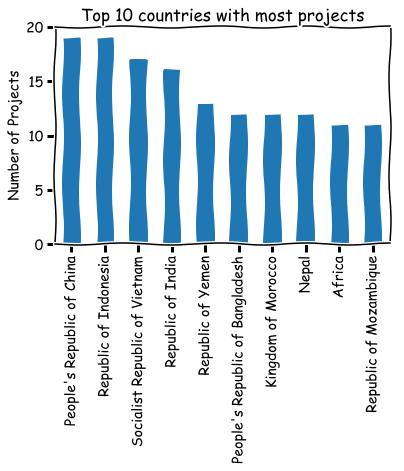

In [759]:
# hiding xlabel throws an ugly MatplotlibDeprecationWarning message, so we hide it for cosmetic purposes
import warnings
warnings.filterwarnings(action='ignore')

# create a new dataframe to plot results
dict_new = { 'count' : top10_count['count'].values.tolist(), 'country' : top10_countries }
result = pd.DataFrame(dict_new)
result.set_index(["country"], inplace=True)  # replaces the numbers in xtick

# this enables settings which can automatically convert any matplotlib plot into XKCD style. Hell yeah!
plt.xkcd() 
ax = result.plot(kind='bar', title='Top 10 countries with most projects', legend=False, rot=90)
ax.set_ylabel('Number of Projects')
plt.ylim(0, 20)

#plt.axes().axes.get_xaxis().set_visible(False) # hide xticks
plt.axes().xaxis.label.set_visible(False)       # hide xlabel
plt.show()

***
## 2. Find the top 10 major project themes (using column 'mjtheme_namecode')

In [760]:
# open json file and normalize column 'mjtheme_namecode'
with open('data/world_bank_projects.json') as f:
    data = json.load(f)

mjtheme_df = json_normalize(data, 'mjtheme_namecode')

# append columns mjtheme_df['code'] and mjtheme_df['name'] to the main DataFrame
result = pd.concat([df, mjtheme_df], axis=1)
#result.head()

### Identify the 10 most expensive projects (assuming _totalcommamt_ is the right column for that)

In [761]:
top10_expensive = result.sort_values(by=['totalcommamt'], ascending=False).head(10)[['totalcommamt','name']]
# top10_expensive.set_index(["totalcommamt"], inplace=True)
# top10_expensive.sort_index(inplace=True, ascending=False)
print(top10_expensive)
top10_expensive.info()

     totalcommamt                                          name
129  1.307800e+09      Financial and private sector development
147  8.000000e+08                             Human development
377  6.500000e+08  Environment and natural resources management
463  6.000000e+08  Environment and natural resources management
49   6.000000e+08                      Public sector governance
101  5.854000e+08  Environment and natural resources management
112  5.500000e+08      Financial and private sector development
110  5.000000e+08  Environment and natural resources management
391  5.000000e+08                                              
6    5.000000e+08  Environment and natural resources management
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 129 to 6
Data columns (total 2 columns):
totalcommamt    10 non-null float64
name            10 non-null object
dtypes: float64(1), object(1)
memory usage: 240.0+ bytes


### Plot this data to "make it look cool"

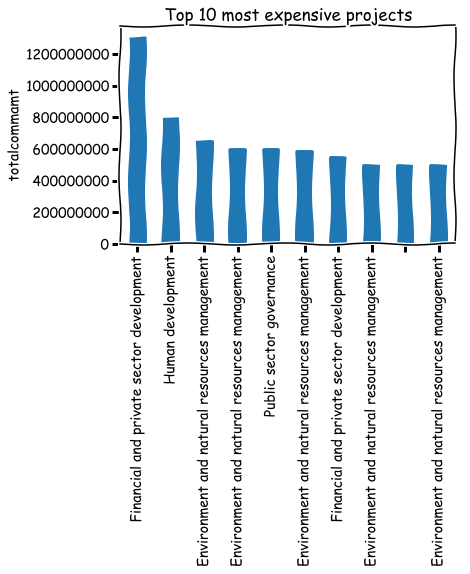

In [762]:
from matplotlib.ticker import FuncFormatter

# a helper function that makes it easier to plot this data's exercise and also exercise 3
def plot_exercise2(df):
    # this enables settings which can automatically convert any matplotlib plot into XKCD style. Hell yeah!
    plt.xkcd() 
    
    ax = top10_expensive.plot(kind='bar', title='Top 10 most expensive projects', legend=False, rot=90)
    ax.set_ylabel('totalcommamt')
    ax.set_xticklabels(top10_expensive.name)

    # I didn't like the log scale in this chart, it looks buggy:
    # ax.set_yscale('log')
    # so instead, show the Y ticks with raw numbers
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%.f' % x))

    plt.show()

    
plot_exercise2(top10_expensive)

***
## 3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.

In [763]:
# Basically, the description of this entire project lacks a lot of information. 
# Replacing empty strings with np.nan was my first solution:
#    import numpy as np
#    top10_expensive = top10_expensive.replace(r'', np.nan, regex=True)

# However, after some careful examinations I noticed the values of columns Code and Name walk hand in hand.
# So if a Name is missing we could probably use it's Code to retrieve the equivalent Name from some other row.

# open json file and normalize column 'mjtheme_namecode'
with open('data/world_bank_projects.json') as f:
    data = json.load(f)

mjtheme_df = json_normalize(data, 'mjtheme_namecode')
#mjtheme_df.head()

### Fix bad data types and create separate lists with all unique Code and Name values

In [764]:
# Fix data types: mjtheme_df.code is of type *object* but should be int
mjtheme_df.code = mjtheme_df.code.astype(int)

# Drop all duplicated entries so we can generate a unique dictionary of <code, name>
codename = mjtheme_df[mjtheme_df.name != ''].drop_duplicates().sort_values(by=['code'])
codename_dict = codename.to_dict(orient='list')

# Divide the dictionary in 2 separate lists
code_list = codename_dict['code']
name_list = codename_dict['name']
#print("codes = ", code_list, "\n")
#print("names = ", name_list)

### Process the DataFrame replacing empty strings in *mjtheme_df.name*  for their Code-equivalent Name

In [765]:
# Complex cleaning: if Name is empty, search the dictionary for an equivalent Name based on its sister Code
def fixMissingName(row):
    if (row['name'] == ''):
        searchCode = int(row['code'])
        for idx, code in enumerate(code_list):
            if (searchCode == code):
                return name_list[idx]
    
    return row['name']             
        
    
# apply the cleanup function to our humble DataFrame and populate empty Name strings appropriately
mjtheme_df['name'] = mjtheme_df.apply(fixMissingName, axis=1)
#mjtheme_df['name'].head()

### Concatenate the DataFrames, same as in exercise 2 and plot the result:

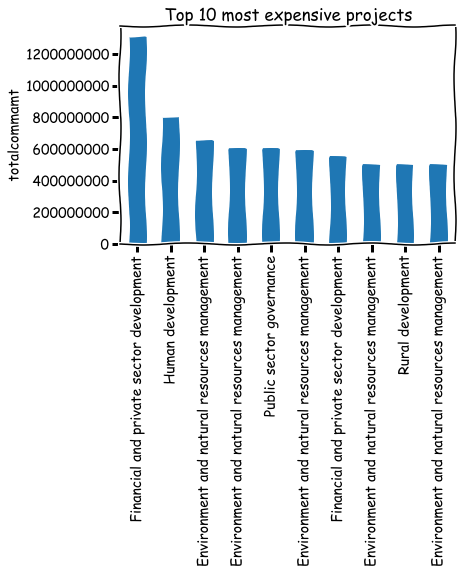

In [766]:
# append columns mjtheme_df['code'] and mjtheme_df['name'] to the main DataFrame
result = pd.concat([df, mjtheme_df], axis=1)
top10_expensive = result.sort_values(by=['totalcommamt'], ascending=False).head(10)[['totalcommamt','name']]
plot_exercise2(top10_expensive)